In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
import os


IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 11  

train_dir = r'o:\Data\datasets\food11\train'
test_dir = r'o:\Data\datasets\food11\test'

In [12]:
# Аугментация данных для тренировочного набора
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Только нормализация для теста
test_datagen = ImageDataGenerator(rescale=1./255)

Создание генераторов данных

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Используем 80% данных для тренировки
)

# Используем часть тренировочных данных для валидации во время обучения
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # Используем 20% данных для валидации
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Получаем названия классов
class_names = list(train_generator.class_indices.keys())
print("Классы:", class_names)

Found 7920 images belonging to 11 classes.
Found 1980 images belonging to 11 classes.
Found 1100 images belonging to 11 classes.
Классы: ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']


Проверка сбалансированности данных

In [14]:
print("\nПроверка распределения классов:")
train_class_counts = np.bincount(train_generator.classes)
val_class_counts = np.bincount(val_generator.classes)

print("Тренировочные данные:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {train_class_counts[i]} изображений")

print("\nВалидационные данные:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {val_class_counts[i]} изображений")


Проверка распределения классов:
Тренировочные данные:
  apple_pie: 720 изображений
  cheesecake: 720 изображений
  chicken_curry: 720 изображений
  french_fries: 720 изображений
  fried_rice: 720 изображений
  hamburger: 720 изображений
  hot_dog: 720 изображений
  ice_cream: 720 изображений
  omelette: 720 изображений
  pizza: 720 изображений
  sushi: 720 изображений

Валидационные данные:
  apple_pie: 180 изображений
  cheesecake: 180 изображений
  chicken_curry: 180 изображений
  french_fries: 180 изображений
  fried_rice: 180 изображений
  hamburger: 180 изображений
  hot_dog: 180 изображений
  ice_cream: 180 изображений
  omelette: 180 изображений
  pizza: 180 изображений
  sushi: 180 изображений


In [15]:
# Кастомная метрика F1-score
class MacroF1Score(keras.metrics.Metric):
    def __init__(self, name='macro_f1', **kwargs):
        super().__init__(name=name, **kwargs)
        # Создаем отдельные счетчики для каждого класса
        self.true_positives = [self.add_weight(name=f'tp_{i}', initializer='zeros') 
                              for i in range(NUM_CLASSES)]
        self.false_positives = [self.add_weight(name=f'fp_{i}', initializer='zeros') 
                               for i in range(NUM_CLASSES)]
        self.false_negatives = [self.add_weight(name=f'fn_{i}', initializer='zeros') 
                               for i in range(NUM_CLASSES)]

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_labels = tf.argmax(y_pred, axis=1)
        y_true_labels = tf.argmax(y_true, axis=1)
        
        # Для каждого класса вычисляем TP, FP, FN отдельно
        for i in range(NUM_CLASSES):
            # True positives: предсказано i и истина i
            tp = tf.reduce_sum(tf.cast(
                tf.logical_and(
                    tf.equal(y_true_labels, i),
                    tf.equal(y_pred_labels, i)
                ), tf.float32))
            
            # False positives: предсказано i, но истина не i
            fp = tf.reduce_sum(tf.cast(
                tf.logical_and(
                    tf.not_equal(y_true_labels, i),
                    tf.equal(y_pred_labels, i)
                ), tf.float32))
            
            # False negatives: истина i, но предсказано не i
            fn = tf.reduce_sum(tf.cast(
                tf.logical_and(
                    tf.equal(y_true_labels, i),
                    tf.not_equal(y_pred_labels, i)
                ), tf.float32))
            
            self.true_positives[i].assign_add(tp)
            self.false_positives[i].assign_add(fp)
            self.false_negatives[i].assign_add(fn)

    def result(self):
        f1_scores = []
        
        for i in range(NUM_CLASSES):
            precision = self.true_positives[i] / (self.true_positives[i] + self.false_positives[i] + 1e-7)
            recall = self.true_positives[i] / (self.true_positives[i] + self.false_negatives[i] + 1e-7)
            
            f1 = 2 * precision * recall / (precision + recall + 1e-7)
            f1_scores.append(f1)
        
        # Macro averaging: среднее арифметическое F1 по всем классам
        return tf.reduce_mean(f1_scores)

    def reset_states(self):
        for i in range(NUM_CLASSES):
            self.true_positives[i].assign(0.)
            self.false_positives[i].assign(0.)
            self.false_negatives[i].assign(0.)

class PredictionDistributionCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Проверяем распределение предсказаний на валидационных данных
        val_predictions = self.model.predict(val_generator)
        val_pred_classes = np.argmax(val_predictions, axis=1)
        
        unique, counts = np.unique(val_pred_classes, return_counts=True)
        print(f"\nEpoch {epoch+1} - Распределение предсказаний на валидации:")
        for class_idx, count in zip(unique, counts):
            print(f"  {class_names[class_idx]}: {count} ({count/len(val_pred_classes)*100:.1f}%)")
        
        # Если модель предсказывает только один класс - останавливаем обучение
        if len(unique) == 1:
            print("⚠️  Модель предсказывает только один класс! Останавливаем обучение.")
            self.model.stop_training = True

In [16]:
def create_model():
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    
    inputs = keras.Input(shape=(224, 224, 3))
    
    # Нормализация входных данных
    x = layers.Rescaling(1./255)(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Более стабильная архитектура
    x = layers.Dense(256, 
                    activation='relu',
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(128, 
                    activation='relu',
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Выходной слой с правильной инициализацией
    outputs = layers.Dense(NUM_CLASSES, 
                          activation='softmax',
                          kernel_initializer='glorot_uniform')(x)
    
    model = keras.Model(inputs, outputs)
    return model

model = create_model()

# Компиляция модели с F1-score
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.0001,  # МАЛЕНЬКИЙ learning rate!
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy', MacroF1Score()]
)

# Вывод архитектуры модели
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,413,358 (16.84 MB)

 Trainable params: 363,019 (1.38 MB)

 Non-trainable params: 4,050,339 (15.45 MB)

In [17]:
callbacks = [
    PredictionDistributionCallback(),
    keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_f1_score',
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        factor=0.2,
        patience=3,
        monitor='val_f1_score',
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        'best_food_model.h5',
        save_best_only=True,
        monitor='val_f1_score',
        mode='max'
    )
]

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 47s 723ms/step


C:\Users\akaku\AppData\Roaming\Python\Python313\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_f1_score` which is not available. Available metrics are: accuracy,loss,macro_f1,val_accuracy,val_loss,val_macro_f1
  current = self.get_monitor_value(logs)
C:\Users\akaku\AppData\Roaming\Python\Python313\site-packages\keras\src\callbacks\callback_list.py:171: UserWarning: Learning rate reduction is conditioned on metric `val_f1_score` which is not available. Available metrics are: accuracy,loss,macro_f1,val_accuracy,val_loss,val_macro_f1,learning_rate.
  callback.on_epoch_end(epoch, logs)
C:\Users\akaku\AppData\Roaming\Python\Python313\site-packages\keras\src\callbacks\model_checkpoint.py:276: UserWarning: Can save best model only with val_f1_score available.
  if self._should_save_model(epoch, batch, logs, filepath):



Epoch 1 - Распределение предсказаний на валидации:
  omelette: 1980 (100.0%)
⚠️  Модель предсказывает только один класс! Останавливаем обучение.
248/248 ━━━━━━━━━━━━━━━━━━━━ 462s 2s/step - accuracy: 0.0908 - loss: 3.8400 - macro_f1: 0.0905 - val_accuracy: 0.0909 - val_loss: 3.0871 - val_macro_f1: 0.0152 - learning_rate: 1.0000e-04



Оценка на тестовых данных:
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 634ms/step - accuracy: 0.0909 - loss: 3.0871 - macro_f1: 0.0152
Test Accuracy: 0.0909
Test Loss: 3.0871
Test F1-Score: 0.0152


KeyError: 'f1_score'

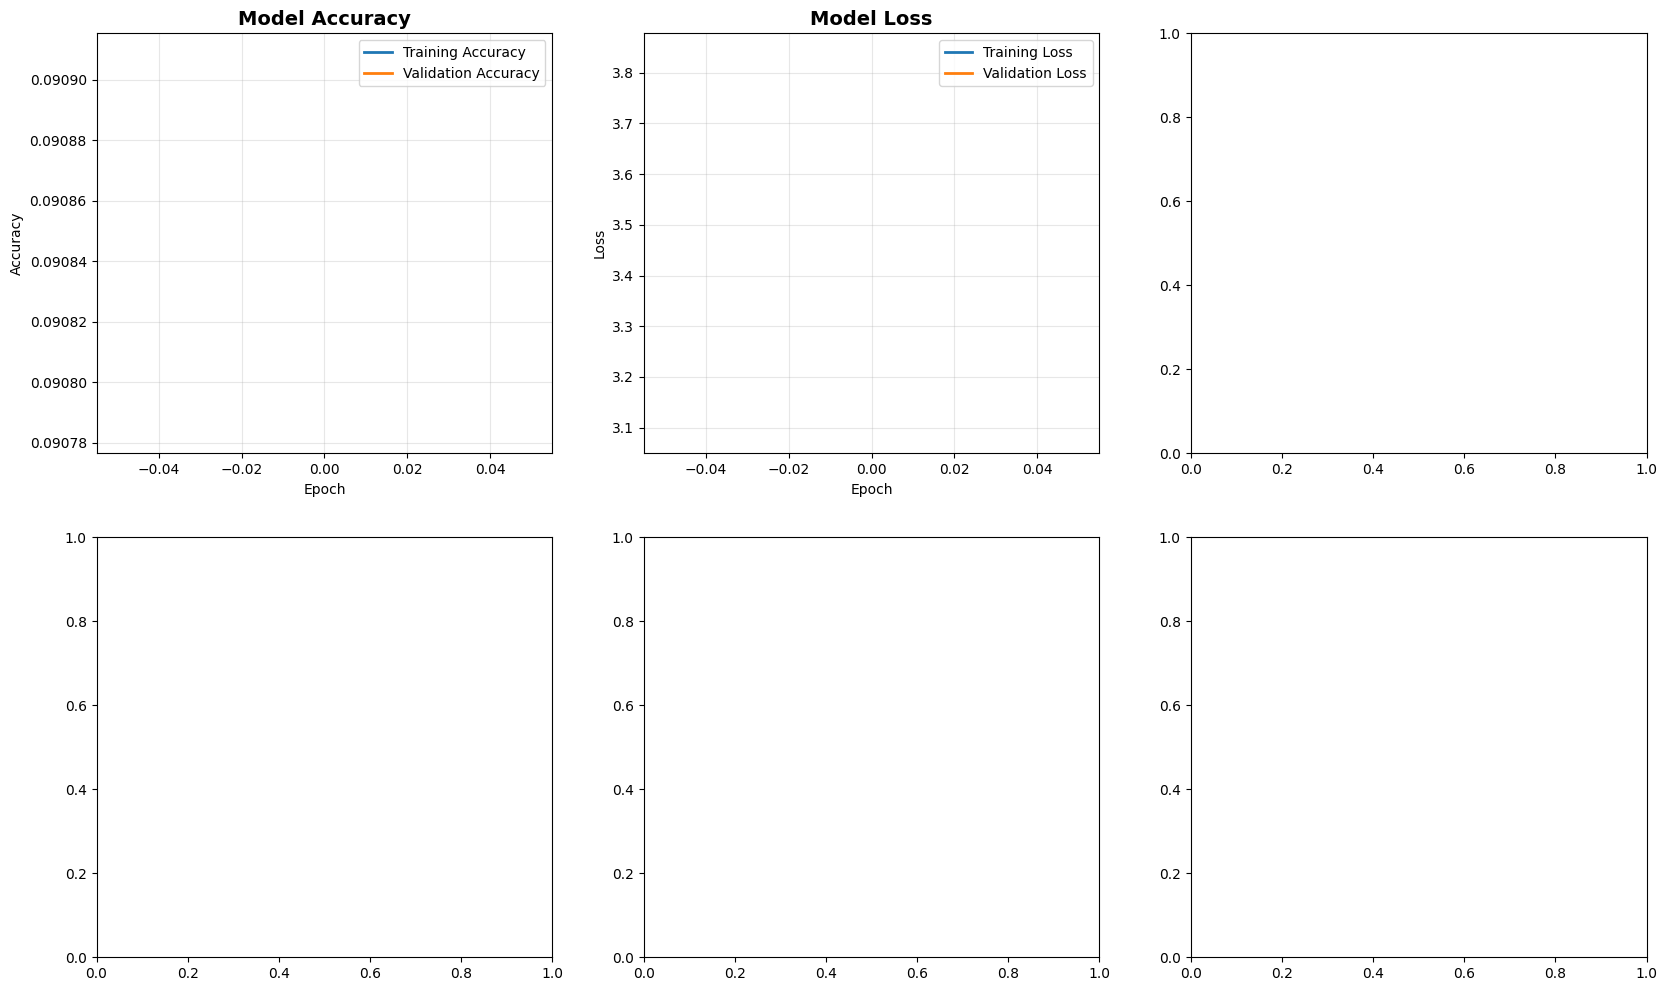

In [18]:
def plot_comprehensive_results(history, model, test_generator, class_names):
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. График точности
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. График потерь
    axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. График F1-score
    axes[0, 2].plot(history.history['f1_score'], label='Training F1-Score', linewidth=2)
    axes[0, 2].plot(history.history['val_f1_score'], label='Validation F1-Score', linewidth=2)
    axes[0, 2].set_title('Model F1-Score', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('F1-Score')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Матрица ошибок на тестовых данных
    # Получаем предсказания для тестового набора
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Нормализованная матрица ошибок
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    im = axes[1, 0].imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    axes[1, 0].set_title('Test Set - Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=axes[1, 0])
    
    tick_marks = np.arange(len(class_names))
    axes[1, 0].set_xticks(tick_marks)
    axes[1, 0].set_yticks(tick_marks)
    axes[1, 0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1, 0].set_yticklabels(class_names)
    
    # Добавляем текстовые аннотации
    thresh = cm_normalized.max() / 2.
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            axes[1, 0].text(j, i, f'{cm_normalized[i, j]:.2f}',
                           ha="center", va="center",
                           color="white" if cm_normalized[i, j] > thresh else "black")
    
    # 5. F1-score по классам на тестовых данных
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred_classes, average=None
    )
    
    classes_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })
    
    x = range(len(class_names))
    axes[1, 1].bar(x, f1, color='skyblue', alpha=0.7)
    axes[1, 1].set_title('Test Set - F1-Score by Class', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Classes')
    axes[1, 1].set_ylabel('F1-Score')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(class_names, rotation=45, ha='right')
    
    # Добавляем значения на столбцы
    for i, v in enumerate(f1):
        axes[1, 1].text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
    
    # 6. Сравнение Precision и Recall на тестовых данных
    x = np.arange(len(class_names))
    width = 0.35
    
    axes[1, 2].bar(x - width/2, precision, width, label='Precision', alpha=0.7)
    axes[1, 2].bar(x + width/2, recall, width, label='Recall', alpha=0.7)
    axes[1, 2].set_title('Test Set - Precision vs Recall by Class', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Classes')
    axes[1, 2].set_ylabel('Score')
    axes[1, 2].set_xticks(x)
    axes[1, 2].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()
    
    return classes_df, y_true, y_pred_classes

# Функция для отображения примеров классификации
def show_classification_examples(model, test_generator, class_names, num_examples=12):
    # Получаем батч данных
    x_batch, y_batch = next(test_generator)
    y_batch_classes = np.argmax(y_batch, axis=1)
    
    # Предсказания
    predictions = model.predict(x_batch)
    predicted_classes = np.argmax(predictions, axis=1)
    confidence = np.max(predictions, axis=1)
    
    # Отображаем примеры
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    axes = axes.ravel()
    
    for i in range(min(num_examples, len(x_batch))):
        axes[i].imshow(x_batch[i])
        
        true_label = class_names[y_batch_classes[i]]
        pred_label = class_names[predicted_classes[i]]
        conf = confidence[i]
        
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}', 
                         color=color, fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Оценка модели на тестовых данных
print("\nОценка на тестовых данных:")
test_loss, test_accuracy, test_f1 = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

# Расширенная визуализация результатов
classes_df, y_true, y_pred_classes = plot_comprehensive_results(
    history, model, test_generator, class_names
)


ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССИФИКАЦИИ НА ТЕСТОВЫХ ДАННЫХ

Classification Report:
               precision    recall  f1-score   support

    apple_pie       0.00      0.00      0.00       100
   cheesecake       0.09      1.00      0.17       100
chicken_curry       0.00      0.00      0.00       100
 french_fries       0.00      0.00      0.00       100
   fried_rice       0.00      0.00      0.00       100
    hamburger       0.00      0.00      0.00       100
      hot_dog       0.00      0.00      0.00       100
    ice_cream       0.00      0.00      0.00       100
     omelette       0.00      0.00      0.00       100
        pizza       0.00      0.00      0.00       100
        sushi       0.00      0.00      0.00       100

     accuracy                           0.09      1100
    macro avg       0.01      0.09      0.02      1100
 weighted avg       0.01      0.09      0.02      1100


F1-Score по классам:
            Class  Precision  Recall  F1-Score  Support
0       apple_pie

C:\Users\akaku\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\akaku\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\akaku\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


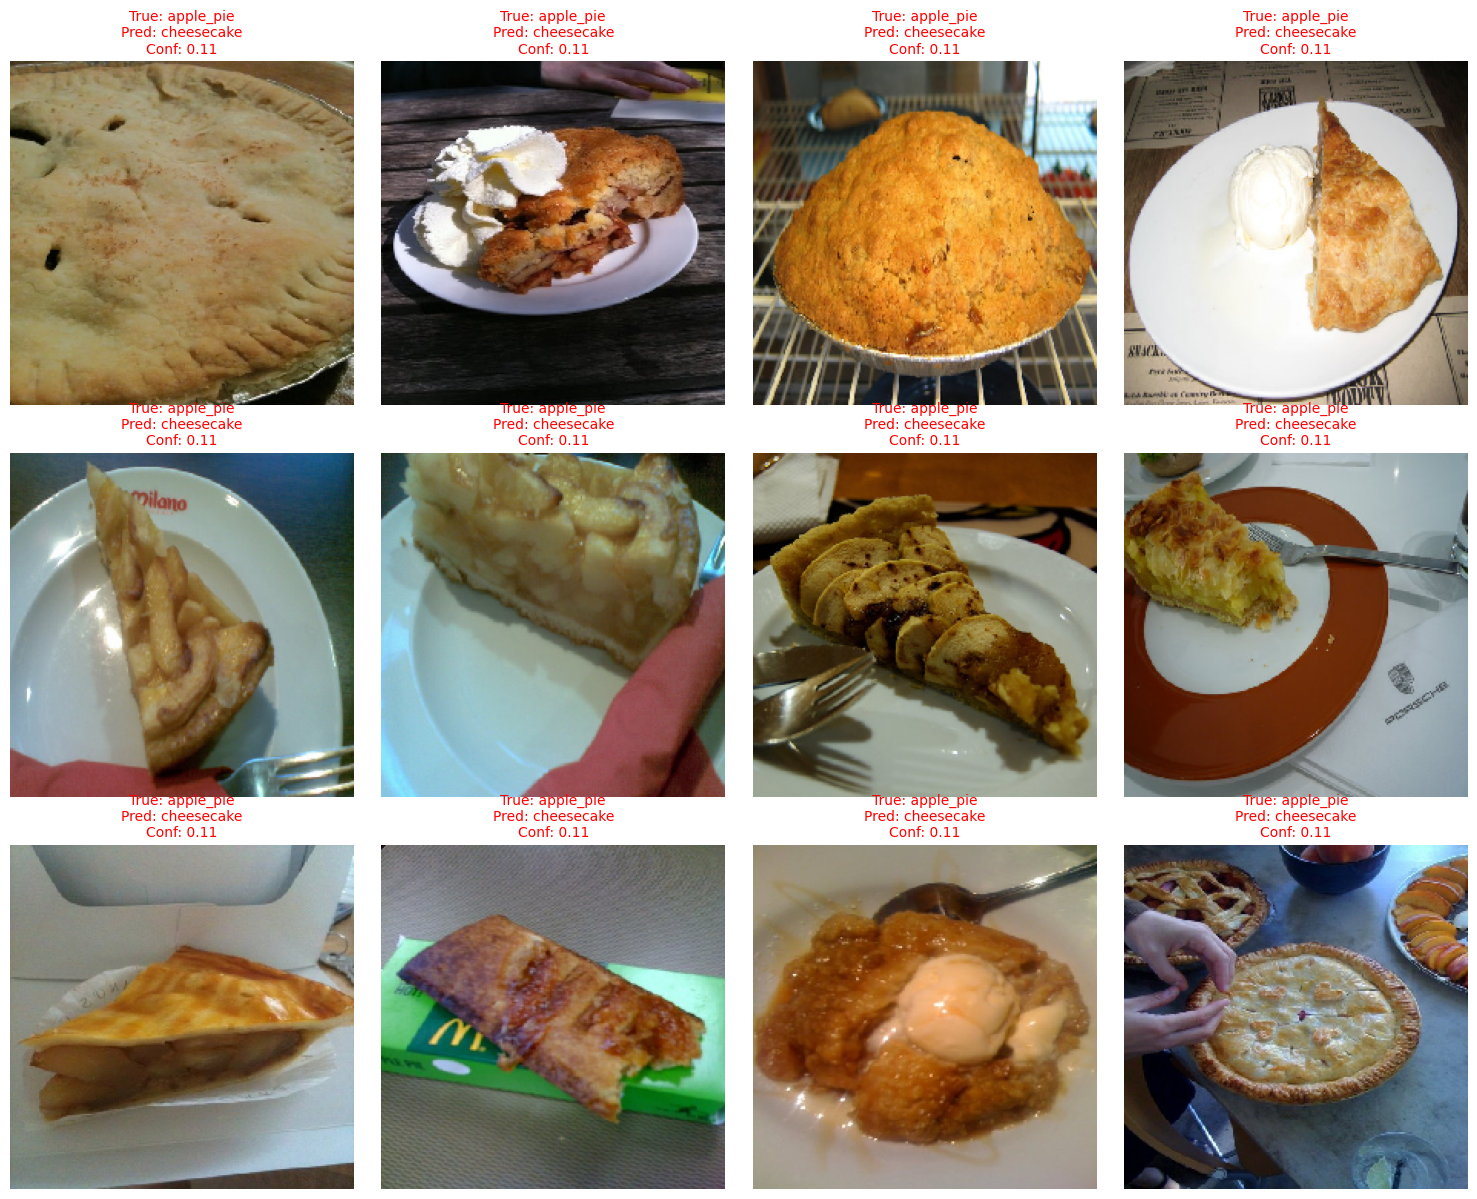


Отображение топ ошибок классификации на тестовых данных...
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 483ms/step


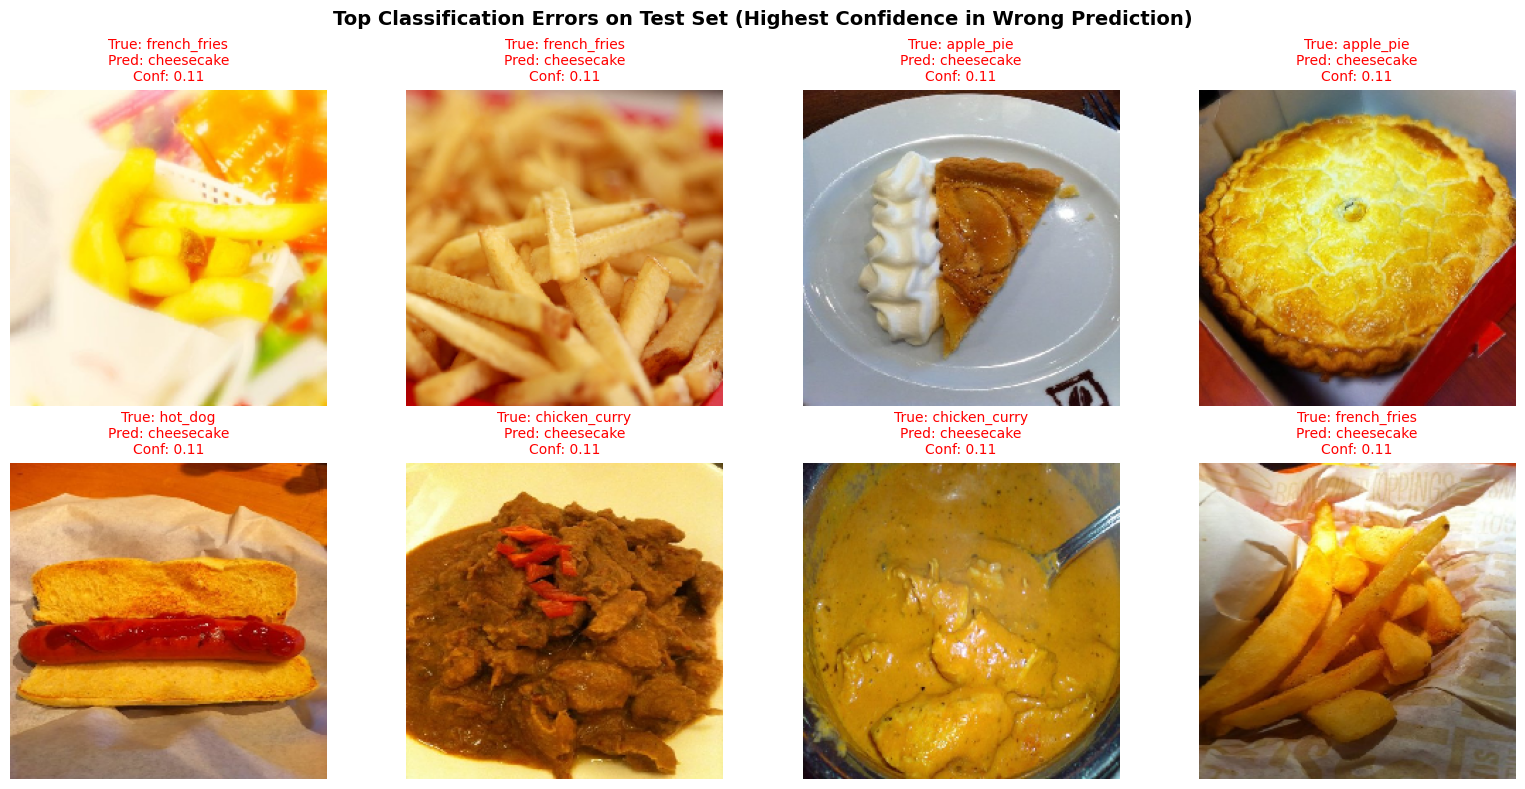


Модель сохранена как 'food11_efficientnet_final.h5'
Результаты сохранены в 'model_results.csv'


In [ ]:
print("\n" + "="*50)
print("ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССИФИКАЦИИ НА ТЕСТОВЫХ ДАННЫХ")
print("="*50)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

print("\nF1-Score по классам:")
print(classes_df.round(3))

# Общая статистика
macro_f1 = f1_score(y_true, y_pred_classes, average='macro')
weighted_f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"\nОбщие метрики на тестовых данных:")
print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

# Отображение примеров классификации
print("\nОтображение примеров классификации на тестовых данных...")
show_classification_examples(model, test_generator, class_names)

# Дополнительная визуализация - топ ошибок классификации
def plot_top_errors(model, test_generator, class_names, top_k=8):
    # Получаем все предсказания
    test_generator.reset()
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    
    # Находим примеры с наибольшей ошибкой
    errors = []
    for i in range(len(y_true)):
        if y_true[i] != y_pred_classes[i]:
            confidence = np.max(y_pred[i])
            errors.append((i, y_true[i], y_pred_classes[i], confidence))
    
    # Сортируем по уверенности в неправильном предсказании
    errors.sort(key=lambda x: x[3], reverse=True)
    
    # Берем топ ошибок
    top_errors = errors[:top_k]
    
    # Отображаем
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    test_generator.reset()
    all_images = []
    all_labels = []
    for _ in range(len(test_generator)):
        x_batch, y_batch = next(test_generator)
        all_images.extend(x_batch)
        all_labels.extend(np.argmax(y_batch, axis=1))
        if len(all_images) >= len(y_true):
            break
    
    for idx, (error_idx, true_class, pred_class, conf) in enumerate(top_errors):
        if error_idx < len(all_images):
            axes[idx].imshow(all_images[error_idx])
            true_label = class_names[true_class]
            pred_label = class_names[pred_class]
            axes[idx].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}', 
                              color='red', fontsize=10)
            axes[idx].axis('off')
    
    plt.suptitle('Top Classification Errors on Test Set (Highest Confidence in Wrong Prediction)', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Отображение топ ошибок
print("\nОтображение топ ошибок классификации на тестовых данных...")
plot_top_errors(model, test_generator, class_names)

# Сохранение финальной модели
model.save('food11_efficientnet_final.h5')
print("\nМодель сохранена как 'food11_efficientnet_final.h5'")

# Сохранение результатов в файл
results_df = pd.DataFrame({
    'Metric': ['Test Accuracy', 'Test Loss', 'Test F1-Score', 'Macro F1-Score', 'Weighted F1-Score'],
    'Value': [test_accuracy, test_loss, test_f1, macro_f1, weighted_f1]
})
results_df.to_csv('model_results.csv', index=False)
print("Результаты сохранены в 'model_results.csv'")